# STAT3612 Group Project

The theme of this semester is interpretable machine learning (IML) with applications to a real datacase study.

For an IML model, both **prediction accuracy and model explainability are equally important**. 
You will need to take both objectives into account when building models in this project.

The data includes about 10,400 anonymized Home Equity Line of Credit (HELOC) loans,together with 23 attributes. 

Note that in the second Excel file the monotonicity constraints are included in the data dictionary, which are based on the prior knowledge about the feature-target effect. 

**Build your IML models based only on the training data**.  
There is no restriction in the choice of feature engineering techniques or machine learning algorithms. 

The final model evaluations will be based on three aspects:
1.  Prediction accuracy as tested on the remaining 20% dataset
2.  Global interpretability about the model effects
3.  Local interpretability about individual predictions (Good/Bad cases from testing data).

## Importing Libraries

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate # printing output as tables

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Reading datasets

In [204]:
pd.set_option('display.max_colwidth', -1) # show complete variable names
heloc = pd.read_csv('HelocData.csv')
dataDict = pd.read_excel('HelocDataDict2.xlsx')
dataDict['Description'] = dataDict['Description'].apply(
    lambda x: x.split('.')[0] if '.' in x else x)[1:] # Only extract the first sentence

In [205]:
#dataDict

In [206]:
#Deal with special values

features = heloc.columns.tolist()[1:] # list of x_i 

median=np.zeros(23)

#Calculate median of every column based on non-special values 

for i in range(0,23):
    median[i]= np.median(heloc[features[i]][(heloc[features[i]] > -7)])   

#First, remove rows with -9, as these rows are missing data in all columns excpet for RiskFlag, and only add noise
#Next impute -8 entries with the median of each column they're in
#Finally, -7 represents a condition not being met, and so should be categorised seperately to other feature values, 
# and so we represent it with negative one

    
for i in range(0,23):
    heloc=heloc[heloc[features[i]] > -9] 
    heloc[features[i]].where(heloc[features[i]]>-8, median[i], inplace=True)
    heloc[features[i]].where(heloc[features[i]]>-7, other=-1, inplace=True)

heloc.head()

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,Bad,75,169,2,59,21,0,0,100,-1,...,36,-1,4,4,43,112,4,6,0,83
1,Bad,66,502,4,145,34,0,0,97,36,...,27,4,3,3,80,53,17,3,12,83
2,Good,69,338,2,62,22,0,0,96,12,...,35,0,4,4,25,100,3,2,1,45
3,Good,75,422,1,91,55,0,0,100,-1,...,33,0,4,4,2,11,12,2,1,57
4,Bad,63,242,2,68,25,0,0,100,-1,...,19,-1,3,3,73,74,12,1,5,87


In [207]:
label_encoder = LabelEncoder()
heloc['RiskFlag'] = label_encoder.fit_transform(heloc['RiskFlag']) # encode 0/1 to RiskFlag

preprocessing finished

In [208]:
GID = 20190006 # group Id
np.random.seed(GID) # set GID as random seed

# create binary 0/1 'good/bad' variable in dataframe
y = heloc['RiskFlag']
X = heloc.drop('RiskFlag', axis=1)

In [209]:
# Compare Algorithms

models = [('LR', LogisticRegression(solver='newton-cg',C=1e6)), 
          ('CART', DecisionTreeClassifier()), 
          ('SVM', SVC(gamma='scale', kernel='rbf')), 
          ('XGB', XGBClassifier())
         ]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
   

LR: 0.729439 (0.008569)
CART: 0.631783 (0.014988)
SVM: 0.728830 (0.005331)
XGB: 0.733292 (0.005743)


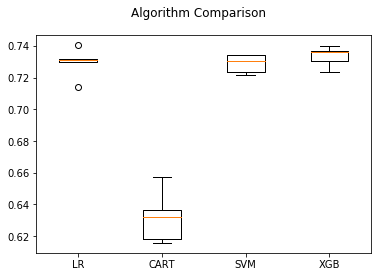

In [210]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the analysis above, logistic regression performs as well as the two black box models, support vector machines and gradient boosted trees.

Logisitic regression gives us a natural way of interpreting the model output- 'probabilities' of repaying a loan.  

## EDA and feature engineering

**NOTE**
10. Max Delq/Public Records Last 12 Months: Values 0-7 are monotonically decreasing (step function)
11. Max Delinquency Ever: Values 2-8 are monotonically decreasing (step function)

In [211]:
# Use the monotonicity constraints in our preprocessing

In [212]:
#dataDict[dataDict['Monotonicity Constraint w.r.t. Prob(Bad = 1)'] == 'Monotonically Increasing']

In [213]:
#dataDict[dataDict['Monotonicity Constraint w.r.t. Prob(Bad = 1)'] == 'Monotonically Decreasing']

In [214]:
''' 
fig = plt.figure(figsize=(15,20))
for i in range(1,len(x_cols)+1):
    plt.subplot(6,4,i)
    sns.boxplot( X_train[x_cols[i-1]], heloc.RiskFlag, )
plt.tight_layout()
plt.show()
'''

' \nfig = plt.figure(figsize=(15,20))\nfor i in range(1,len(x_cols)+1):\n    plt.subplot(6,4,i)\n    sns.boxplot( X_train[x_cols[i-1]], heloc.RiskFlag, )\nplt.tight_layout()\nplt.show()\n'

In [215]:
corr = heloc.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
RiskFlag,1,0.46,0.21,0.054,0.25,0.14,-0.17,-0.14,0.26,-0.036,0.24,0.22,0.1,-0.078,-0.14,0.17,-0.14,-0.14,-0.35,-0.049,-0.13,-0.052,-0.24,-0.28
x1,0.46,1,0.25,0.15,0.33,0.00017,-0.41,-0.34,0.51,-0.1,0.57,0.5,-0.039,-0.19,-0.17,0.15,-0.21,-0.21,-0.62,-0.032,-0.34,-0.18,-0.45,-0.45
x2,0.21,0.25,1,0.1,0.69,0.24,-0.012,-0.028,0.039,0.029,-0.0082,-0.0033,0.27,-0.11,-0.19,0.087,-0.11,-0.1,-0.17,-0.071,0.12,-0.03,-0.0043,-0.22
x3,0.054,0.15,0.1,1,0.4,-0.25,0.027,0.026,-0.13,-0.044,-7.8e-05,0.011,-0.22,-0.46,-0.025,0.049,-0.17,-0.18,-0.061,-0.093,-0.17,-0.16,-0.079,-0.0065
x4,0.25,0.33,0.69,0.4,1,0.12,0.038,0.013,-0.044,0.031,-0.016,-0.035,0.09,-0.35,-0.2,0.09,-0.18,-0.18,-0.19,-0.1,0.012,-0.12,-0.049,-0.21
x5,0.14,0.00017,0.24,-0.25,0.12,1,-0.12,-0.12,0.26,0.029,-0.006,0.039,0.85,0.31,-0.13,0.032,0.096,0.097,-0.069,-0.042,0.48,0.35,0.22,-0.23
x6,-0.17,-0.41,-0.012,0.027,0.038,-0.12,1,0.89,-0.53,0.19,-0.42,-0.59,-0.025,-0.057,0.11,-0.062,0.038,0.038,0.09,-0.0082,-0.05,0.029,-0.021,0.11
x7,-0.14,-0.34,-0.028,0.026,0.013,-0.12,0.89,1,-0.38,0.16,-0.37,-0.5,-0.04,-0.05,0.11,-0.057,0.041,0.041,0.062,0.0003,-0.063,0.013,-0.033,0.097
x8,0.26,0.51,0.039,-0.13,-0.044,0.26,-0.53,-0.38,1,-0.21,0.51,0.64,0.17,0.15,-0.13,0.07,0.0066,0.0081,-0.16,0.025,0.079,0.047,-0.0027,-0.18
x9,-0.036,-0.1,0.029,-0.044,0.031,0.029,0.19,0.16,-0.21,1,-0.072,-0.49,0.04,0.033,0.049,-0.012,0.013,0.013,0.055,0.022,0.016,0.025,0.011,0.037


Logistic Regression requires the features to be uncorrelated, so we must remove or combine features so as to not have heavily correlated ones inlcuded in the model

In [216]:
# new features 
heloc_tmp=heloc.copy()

#First we will deal with highly correlated features

#First we will combine x6 and x7 

heloc_tmp['x24']=(heloc['x2']-heloc['x3'])

heloc_tmp['x25']=heloc['x8']*heloc_tmp['x4']

#Then we combine x5 and x12 to find satisfactory trades as a fraction of total trades

#heloc_tmp['x25']=heloc['x5']/(heloc['x12']+0.1)

#x2 and x4 are also highly correlated so we combine them

heloc_tmp['x26']= heloc['x2']/heloc['x4']

heloc_tmp['x27']=(.7*heloc['x16'])+(.3*heloc['x17'])-heloc['x15']

heloc_tmp['x28']=(heloc['x19']*heloc['x21'])/(heloc['x14']+1)

heloc_tmp['x29']=heloc['x21']/(heloc_tmp['x12']*heloc_tmp['x14']+0.1)#number of installment trades

#heloc_tmp['x30']= heloc_tmp['x29']* heloc_tmp['x19']#amount of intsallment trades

heloc_tmp['x30']=heloc['x5']*heloc['x4']

#heloc['x14']+heloc['x19']+heloc['x21']


#heloc_tmp['x28']=heloc_tmp['x15']+heloc['x16']+heloc_tmp['x17']
#heloc_tmp['x29']=heloc_tmp['x18']+heloc_tmp['x20']
#heloc_tmp['x30']=heloc_tmp['x18']+heloc_tmp['x22']
#heloc_tmp['x31']=heloc_tmp['x19']+heloc_tmp['x23']#

heloc_tmp

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,0,75,169,2,59,21,0,0,100,-1,...,6,0,83,167,5900,2.864407,5.0,18.162162,0.007575,1239
1,0,66,502,4,145,34,0,0,97,36,...,3,12,83,498,14065,3.462069,-1.0,5.678571,0.003003,4930
2,1,69,338,2,62,22,0,0,96,12,...,2,1,45,336,5952,5.451613,4.0,5.555556,0.002484,1364
3,1,75,422,1,91,55,0,0,100,-1,...,2,1,57,421,9100,4.637363,4.0,0.647059,0.001063,5005
4,0,63,242,2,68,25,0,0,100,-1,...,1,5,87,240,6800,3.558824,4.0,3.700000,0.002024,1700
5,0,74,193,1,91,19,0,0,100,-1,...,2,4,73,192,9100,2.120879,2.0,8.315789,0.005049,1729
6,0,58,247,2,62,30,0,0,94,1,...,2,2,89,245,5828,3.983871,-9.0,4.000000,0.001838,1860
7,1,89,203,6,79,28,0,0,97,62,...,2,0,33,197,7663,2.569620,-20.0,3.333333,0.001110,2212
8,1,89,357,1,125,15,0,0,100,-1,...,2,0,55,356,12500,2.856000,0.7,1.550000,0.002849,1875
9,0,63,240,4,64,20,1,0,86,45,...,1,3,70,236,5504,3.750000,-3.0,6.727273,0.004760,1280


In [217]:
features_tmp=heloc_tmp.columns.tolist()[1:] # updated list of features
features_tmp

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x28',
 'x29',
 'x30']

In [218]:
heloc_train, heloc_test = train_test_split(heloc_tmp, test_size=0.2, random_state=GID) # 80/20 train/test split

In [219]:
# Binning

import scorecardpy as sc

heloc_train_tmp=heloc_train.copy()
heloc_test_tmp=heloc_test.copy()

for i in range(len(features_tmp)):
    bins = sc.woebin(heloc_train_tmp, y='RiskFlag',x=features_tmp[i], method='tree')
    breaks = np.insert(bins[features_tmp[i]]['breaks'].values.astype(np.float), 0, -np.inf)

    heloc_train_tmp[features_tmp[i]] = pd.cut(heloc_train_tmp[features_tmp[i]], bins=breaks, right=True)
    heloc_test_tmp[features_tmp[i]] = pd.cut(heloc_test_tmp[features_tmp[i]], bins=breaks, right=True)


[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...


In [220]:
heloc_train_tmp.head()

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
1679,0,"(-inf, 68.0]","(130.0, 260.0]","(2.0, 10.0]","(75.0, inf]","(25.0, inf]","(-inf, 1.0]","(-inf, 1.0]","(95.0, 97.0]","(24.0, inf]",...,"(-inf, 2.0]","(1.0, 3.0]","(72.0, 88.0]","(130.0, 210.0]","(5500.0, 8000.0]","(2.0, 3.0]","(4.0, inf]","(2.0, 5.0]","(-inf, 0.003]","(2200.0, inf]"
7639,1,"(84.0, inf]","(130.0, 260.0]","(20.0, inf]","(75.0, inf]","(14.0, 25.0]","(-inf, 1.0]","(-inf, 1.0]","(97.0, inf]","(-inf, 0.0]",...,"(-inf, 2.0]","(-inf, 1.0]","(-inf, 46.0]","(130.0, 210.0]","(5500.0, 8000.0]","(2.0, 3.0]","(2.0, 4.0]","(5.0, 7.0]","(0.004, 0.005]","(1200.0, 2200.0]"
45,1,"(-inf, 68.0]","(90.0, 130.0]","(-inf, 2.0]","(30.0, 55.0]","(25.0, inf]","(-inf, 1.0]","(-inf, 1.0]","(97.0, inf]","(-inf, 0.0]",...,"(4.0, inf]","(1.0, 3.0]","(88.0, inf]","(80.0, 130.0]","(-inf, 4500.0]","(2.0, 3.0]","(2.0, 4.0]","(13.0, inf]","(0.004, 0.005]","(1200.0, 2200.0]"
3074,1,"(75.0, 84.0]","(130.0, 260.0]","(2.0, 10.0]","(75.0, inf]","(25.0, inf]","(-inf, 1.0]","(-inf, 1.0]","(97.0, inf]","(-inf, 0.0]",...,"(2.0, 3.0]","(-inf, 1.0]","(72.0, 88.0]","(130.0, 210.0]","(8000.0, inf]","(-inf, 2.0]","(-inf, 0.0]","(5.0, 7.0]","(0.005, 0.011]","(2200.0, inf]"
2794,0,"(-inf, 68.0]","(260.0, inf]","(2.0, 10.0]","(75.0, inf]","(25.0, inf]","(-inf, 1.0]","(-inf, 1.0]","(84.0, 95.0]","(0.0, 14.0]",...,"(2.0, 3.0]","(1.0, 3.0]","(88.0, inf]","(210.0, 260.0]","(8000.0, inf]","(2.0, 3.0]","(0.0, 1.0]","(5.0, 7.0]","(-inf, 0.003]","(2200.0, inf]"


In [221]:
# Discretize into categorical variables

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for i in range(len(features_tmp)):
    heloc_train_tmp[features_tmp[i]] = label_encoder.fit_transform(heloc_train_tmp[features_tmp[i]])
    heloc_test_tmp[features_tmp[i]] = label_encoder.fit_transform(heloc_test_tmp[features_tmp[i]])

heloc_train_tmp.head()

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
1679,0,0,2,1,3,3,0,0,2,3,...,0,1,3,2,2,1,4,1,0,3
7639,1,3,2,4,3,2,0,0,3,0,...,0,0,0,2,2,1,3,2,2,2
45,1,0,1,0,1,3,0,0,3,0,...,3,1,4,1,0,1,3,4,2,2
3074,1,2,2,1,3,3,0,0,3,0,...,1,0,3,2,3,0,0,2,3,3
2794,0,0,3,1,3,3,0,0,1,1,...,1,1,4,3,3,1,1,2,0,3


https://mlwhiz.com/blog/2019/08/07/feature_selection/

# Feature Selection

In [222]:
num_feats=25
X = heloc_train_tmp.drop('RiskFlag', axis=1)
y = heloc_train_tmp['RiskFlag']

In [223]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

25 selected features


In [224]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LogisticRegression(solver='lbfgs'), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 30 features.
25 selected features


In [225]:
from sklearn.feature_selection import SelectFromModel

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

25 selected features


In [226]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

13 selected features


In [227]:
from sklearn.feature_selection import SelectFromModel

xgbc=XGBClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_xgb_selector = SelectFromModel(xgbc, max_features=num_feats)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

11 selected features


In [228]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=500)

embeded_etc_selector=SelectFromModel(etc, max_features=num_feats)
embeded_etc_selector.fit(X, y)

embeded_etc_support=embeded_etc_selector.get_support()
embeded_etc_feature= X.loc[:,embeded_etc_support].columns.tolist()
print(str(len(embeded_etc_feature)), 'selected features')

13 selected features


In [229]:
feature_selection_df = pd.DataFrame(
    {'Feature':features_tmp, 'Chi-2':chi_support, 
     'RFE':rfe_support, 'Logistics':embeded_lr_support,
     'Random Forest':embeded_rf_support, 'XGB':embeded_xgb_support,
     'ETC' :embeded_etc_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display features by importance
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [230]:
feature_selection_df

,Feature,Chi-2,RFE,Logistics,Random Forest,XGB,ETC,Total
1,x8,True,True,True,True,True,True,6
2,x30,True,True,True,True,True,True,6
3,x25,True,True,True,True,True,True,6
4,x23,True,True,True,True,True,True,6
5,x18,True,True,True,True,True,True,6
6,x1,True,True,True,True,True,True,6
7,x27,True,True,True,True,False,True,5
8,x24,True,True,True,True,False,True,5
9,x4,True,True,True,False,True,False,4
10,x3,False,True,True,True,False,True,4


In [231]:
drop=feature_selection_df[feature_selection_df['Total'] <3]['Feature'].tolist()
print(drop)

['x28', 'x11', 'x6', 'x13', 'x12']


In [232]:
corr = heloc_train_tmp.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
RiskFlag,1,0.46,0.22,0.056,0.26,0.15,-0.14,-0.11,0.29,-0.11,0.27,0.23,0.11,-0.069,-0.15,0.18,-0.14,-0.13,-0.36,-0.082,-0.12,-0.069,-0.19,-0.28,0.21,0.33,0.0038,-0.21,0.017,-0.06,0.26
x1,0.46,1,0.24,0.16,0.31,0.024,-0.31,-0.24,0.54,-0.28,0.58,0.51,-0.031,-0.18,-0.14,0.13,-0.21,-0.21,-0.62,-0.089,-0.32,-0.2,-0.39,-0.43,0.22,0.43,-0.041,-0.24,-0.032,-0.0079,0.19
x2,0.22,0.24,1,0.089,0.67,0.3,0.0072,-0.014,-0.02,0.052,-0.044,-0.06,0.32,-0.097,-0.16,0.08,-0.099,-0.094,-0.16,-0.099,0.1,-0.017,0.022,-0.21,0.92,0.66,0.46,-0.14,0.053,-0.21,0.55
x3,0.056,0.16,0.089,1,0.25,-0.24,0.035,0.04,-0.061,-0.038,-0.011,0.012,-0.23,-0.39,0.0038,0.0079,-0.23,-0.23,-0.053,-0.21,-0.17,-0.21,-0.086,0.012,0.0034,0.22,-0.23,-0.22,-0.16,0.066,-0.028
x4,0.26,0.31,0.67,0.25,1,0.28,0.054,0.021,-0.073,0.073,-0.071,-0.094,0.23,-0.3,-0.16,0.094,-0.18,-0.17,-0.19,-0.16,0.046,-0.085,-0.0035,-0.22,0.63,0.87,-0.076,-0.21,-0.018,-0.18,0.64
x5,0.15,0.024,0.3,-0.24,0.28,1,-0.11,-0.12,0.13,0.038,-0.029,-0.051,0.8,0.21,-0.16,0.078,0.068,0.069,-0.057,0.0052,0.42,0.32,0.22,-0.26,0.32,0.33,0.18,0.031,0.25,-0.36,0.77
x6,-0.14,-0.31,0.0072,0.035,0.054,-0.11,1,0.8,-0.41,0.22,-0.3,-0.29,-0.017,-0.045,0.11,-0.055,0.028,0.034,0.072,-0.0094,-0.046,0.032,-0.042,0.1,-0.0089,-0.11,-0.058,0.055,-0.072,-0.043,-0.066
x7,-0.11,-0.24,-0.014,0.04,0.021,-0.12,0.8,1,-0.28,0.18,-0.22,-0.2,-0.048,-0.046,0.11,-0.054,0.032,0.039,0.038,-6.7e-05,-0.071,0.0095,-0.065,0.08,-0.027,-0.094,-0.051,0.062,-0.071,-0.023,-0.081
x8,0.29,0.54,-0.02,-0.061,-0.073,0.13,-0.41,-0.28,1,-0.63,0.8,0.88,0.06,0.099,-0.11,0.079,-0.0094,-0.0084,-0.19,0.0057,-0.01,-0.027,-0.031,-0.17,-0.0044,0.16,0.056,-0.048,0.098,0.033,0.089
x9,-0.11,-0.28,0.052,-0.038,0.073,0.038,0.22,0.18,-0.63,1,-0.46,-0.8,0.065,0.01,0.059,-0.03,0.038,0.039,0.096,0.021,0.044,0.055,0.036,0.056,0.05,-0.028,0.0025,0.051,-0.023,-0.08,0.049


Based on the ranked table of features, and on the correlation matrix, we remove variables

In [233]:
heloc_train_tmp_tmp=heloc_train_tmp.drop(drop,axis=1)

In [234]:
corr = heloc_train_tmp_tmp.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RiskFlag,x1,x2,x3,x4,x5,x7,x8,x9,x10,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x29,x30
RiskFlag,1,0.46,0.22,0.056,0.26,0.15,-0.11,0.29,-0.11,0.27,-0.15,0.18,-0.14,-0.13,-0.36,-0.082,-0.12,-0.069,-0.19,-0.28,0.21,0.33,0.0038,-0.21,-0.06,0.26
x1,0.46,1,0.24,0.16,0.31,0.024,-0.24,0.54,-0.28,0.58,-0.14,0.13,-0.21,-0.21,-0.62,-0.089,-0.32,-0.2,-0.39,-0.43,0.22,0.43,-0.041,-0.24,-0.0079,0.19
x2,0.22,0.24,1,0.089,0.67,0.3,-0.014,-0.02,0.052,-0.044,-0.16,0.08,-0.099,-0.094,-0.16,-0.099,0.1,-0.017,0.022,-0.21,0.92,0.66,0.46,-0.14,-0.21,0.55
x3,0.056,0.16,0.089,1,0.25,-0.24,0.04,-0.061,-0.038,-0.011,0.0038,0.0079,-0.23,-0.23,-0.053,-0.21,-0.17,-0.21,-0.086,0.012,0.0034,0.22,-0.23,-0.22,0.066,-0.028
x4,0.26,0.31,0.67,0.25,1,0.28,0.021,-0.073,0.073,-0.071,-0.16,0.094,-0.18,-0.17,-0.19,-0.16,0.046,-0.085,-0.0035,-0.22,0.63,0.87,-0.076,-0.21,-0.18,0.64
x5,0.15,0.024,0.3,-0.24,0.28,1,-0.12,0.13,0.038,-0.029,-0.16,0.078,0.068,0.069,-0.057,0.0052,0.42,0.32,0.22,-0.26,0.32,0.33,0.18,0.031,-0.36,0.77
x7,-0.11,-0.24,-0.014,0.04,0.021,-0.12,1,-0.28,0.18,-0.22,0.11,-0.054,0.032,0.039,0.038,-6.7e-05,-0.071,0.0095,-0.065,0.08,-0.027,-0.094,-0.051,0.062,-0.023,-0.081
x8,0.29,0.54,-0.02,-0.061,-0.073,0.13,-0.28,1,-0.63,0.8,-0.11,0.079,-0.0094,-0.0084,-0.19,0.0057,-0.01,-0.027,-0.031,-0.17,-0.0044,0.16,0.056,-0.048,0.033,0.089
x9,-0.11,-0.28,0.052,-0.038,0.073,0.038,0.18,-0.63,1,-0.46,0.059,-0.03,0.038,0.039,0.096,0.021,0.044,0.055,0.036,0.056,0.05,-0.028,0.0025,0.051,-0.08,0.049
x10,0.27,0.58,-0.044,-0.011,-0.071,-0.029,-0.22,0.8,-0.46,1,-0.087,0.059,-0.038,-0.039,-0.18,-0.0036,-0.11,-0.099,-0.072,-0.13,-0.035,0.1,0.00028,-0.06,0.076,-0.035


In [235]:
heloc_train=heloc_train_tmp.drop(drop,axis=1)
heloc_test=heloc_test_tmp.drop(drop,axis=1)

# Model Building

In [236]:
X_train = heloc_train.drop('RiskFlag', axis=1)
y_train = heloc_train['RiskFlag']
X_test = heloc_test.drop('RiskFlag', axis=1)
y_test = heloc_test['RiskFlag']

## Hyperparameter tuning

In [255]:
## Hyperparameter tuning

lr = LogisticRegression()
param_grid_1 = dict(penalty = ['l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=[ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], multi_class=['ovr'], class_weight=[None,'balanced'])
param_grid_2 = dict(penalty = ['l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=[ 'newton-cg', 'lbfgs','sag', 'saga'], multi_class=['ovr','multinomial'],class_weight=[None,'balanced'])
param_grid_3 = dict(penalty = ['l1', 'l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=['liblinear', 'saga'], multi_class=['ovr'],class_weight=[None,'balanced'])
param_grid_4 = dict(penalty = ['l1', 'l2', 'elasticnet' ], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=['saga'], multi_class=['ovr','multinomial'],class_weight=[None,'balanced'])

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_1,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_2,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_4,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7398609446792573
Best Params:  {'C': 0.1, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   34.0s finished


Best Score:  0.7401145908428591
Best Params:  {'C': 0.001, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 313 out of 320 | elapsed:   12.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7398609446792573
Best Params:  {'C': 0.1, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   19.9s finished


Best Score:  0.7401145908428591
Best Params:  {'C': 0.001, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}


In [273]:
lr = LogisticRegression(penalty='l2',C=0.001,solver='newton-cg',multi_class='ovr')
lr=lr.fit(X_train, y_train)

y_pred=lr.predict(X_test)

acc_test = accuracy_score(y_test,y_pred)
print(acc_test)

0.7263051191079575


## Model Evaluation

In [251]:
# we will calculate train and test error rates for all models
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

In [252]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

acc_train = accuracy_score(y_train,y_train_pred)
acc_test = accuracy_score(y_test,y_test_pred)
    
print('The Acc on training set:',acc_train)
print('The Acc on testing set:',acc_test)

The Acc on training set: 0.7417596348884381
The Acc on testing set: 0.7298530157121136
